# 1. 메모리 변수 제거

In [1]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

## 기본 세팅

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 텐서플로우 일일 빌드버전
!pip install -q tf-nightly

     |████████████████████████████████| 492.6 MB 2.5 kB/s 
     |████████████████████████████████| 1.4 MB 50.0 MB/s 
     |████████████████████████████████| 462 kB 58.2 MB/s 
     |████████████████████████████████| 5.8 MB 43.3 MB/s 


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab.patches import cv2_imshow # cv2.imshow 대신 사용

In [5]:
# pathlib를 통해 경로관리 편하게

import pathlib

path = pathlib.Path('/content/drive/MyDrive/T1_PJ/DATA/이미지 폴더')

In [6]:
model = tf.keras.models.load_model('/content/drive/MyDrive/T1_PJ/CODE/PET_model_V3.h5')

In [7]:
class_names = ['재활용가능 어그멘테이션', '재활용불가능 어그멘테이션']

In [8]:
test_path = '/content/drive/MyDrive/T1_PJ/DATA/test'

## 이미지로 인식

In [9]:
##### 실행 #####
# 이미지를 저장하지 않을 경우
# sudo python3 object_detection_image.py --input 이미지 경로
# 예) sudo python3 object_detection_image.py --input ./test_image/test_image_1.jpg
#
# 이미지를 저장할 경우
# sudo python3 object_detection_image.py --input 이미지 경로 --output 저장할 이미지 경로
# 예) sudo python3 object_detection_image.py --input ./test_image/test_image_1.jpg --output ./result_image/result_image_1.jpg

# 필요한 패키지 import
import numpy as np # 파이썬 행렬 수식 및 수치 계산 처리 모듈
import cv2 # opencv 모듈
import easydict # argparse가 쥬피터에선 안됨

In [10]:
# 훈련된 클래스 labels 목록을 초기화
CLASSES = ['재활용가능 어그멘테이션', '재활용불가능 어그테이션']

# 각 클래스에 대한 bounding box 색깔 random 지정
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# 모델(caffemodel 및 prototxt) load
print("[모델 loading...]")
# net = cv2.dnn.readNetFromCaffe(path + "MobileNetSSD_deploy.prototxt.txt", path + "MobileNetSSD_deploy.caffemodel")
model = tf.keras.models.load_model('/content/drive/MyDrive/T1_PJ/CODE/PET_model_V3.h5')

[모델 loading...]


In [115]:
# 실행을 할 때 인자값 추가
opt2 = easydict.EasyDict({
        "input": test_path + '/pet10.jpg', # input 경로
        "output": '', # output 경로
        "confidence": 0.5 # 최소 확률
})
# 입력받은 인자값을 args에 저장
args2 = vars(opt2)

이 사진은 81.31219744682312% 확률로 재활용가능 어그멘테이션 입니다


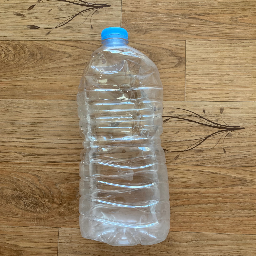

-1

In [116]:
# input 이미지 읽기
image = cv2.imread(args2["input"])

image2 = cv2.resize(image, (256,256))
    
img_array = tf.expand_dims(image2, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')

# 이미지 show
cv2_imshow(image2)
cv2.waitKey(0)

## 객체 테두리 검출 함수 테스트

<SimpleBlobDetector 0x7f780c6dd130>


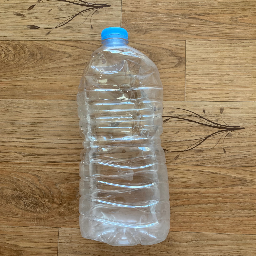

In [117]:
# SimpleBolbDetector 검출기 (kpt_blob.py)
image = cv2.imread(args2["input"])

image2 = cv2.resize(image, (256,256))

img = image2
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# SimpleBlobDetector 생성 ---①
detector = cv2.SimpleBlobDetector_create()
print(detector)
# 키 포인트 검출 ---②
keypoints = detector.detect(gray)
# print(keypoints)
# 키 포인트를 빨간색으로 표시 ---③
img = cv2.drawKeypoints(img, keypoints, None, (0,0,255),\
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# x1, y1, x2, y2 = return_rect_points(keypoints)
# print(x1, y1, x2, y2)
# cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255))

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

33 5 243 181


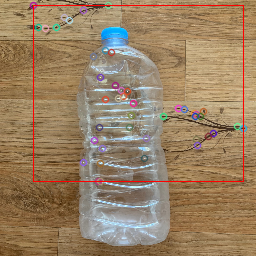

-1

In [118]:
# FAST로 특징점 검출 (kpt_fast.py)
image = cv2.imread(args2["input"])

image2 = cv2.resize(image, (256,256))

img = image2
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# FASt 특징 검출기 생성 ---①
fast = cv2.FastFeatureDetector_create(80)
# 특징점 검출 ---②
keypoints = fast.detect(gray, None)
# 특징점 그리기 ---③
img = cv2.drawKeypoints(img, keypoints, None)

x1, y1, x2, y2 = return_rect_points(keypoints)
print(x1, y1, x2, y2)
cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255))

# 결과 출력 ---④
cv2_imshow(img)
cv2.waitKey()

In [ ]:
pts = cv2.KeyPoint_convert(keypoints)
pts

## keypoints 사용

In [119]:
# cv2. keypoints 해제 후 테두리 값 리턴

def return_rect_points(keypoints):
  pts = cv2.KeyPoint_convert(keypoints)
  x1 = 300.0 # 최대값은 256을 넘을 수 없음
  x2 = 0.0 
  y1 = 300.0 # 최대값은 256을 넘을 수 없음
  y2 = 0.0 

  for pt in pts:
    x, y = pt
    x1 = min(x1, x)
    x2 = max(x2, x)
    y1 = min(y1, y)
    y2 = max(y2, y)

  return (int(x1), int(y1), int(x2), int(y2))

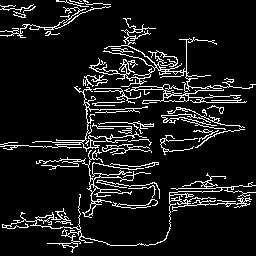

-1

In [121]:
blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0)
ret, thresh1 = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
edged = cv2.Canny(blur, 10, 250)
cv2_imshow(edged)
cv2.waitKey(0)

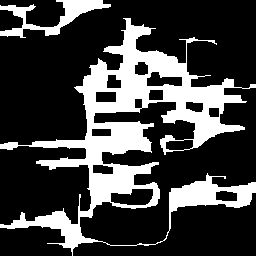

-1

In [122]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
cv2_imshow(closed)
cv2.waitKey(0)

In [123]:
contours, _ = cv2.findContours(closed.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total = 0

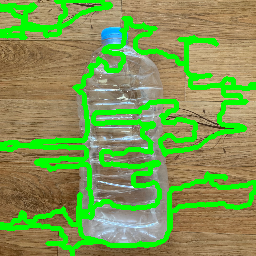

In [124]:
# 외곽선 그리는 용도. 이미지에 그리기 때문에 이 코드 적용하면 원래 이미지에
# 초록색 선 생김
contours_image = cv2.drawContours(image2, contours, -1, (0,255,0), 3)
cv2_imshow(contours_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

33 5 243 181


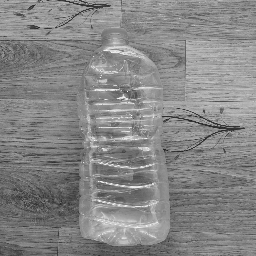

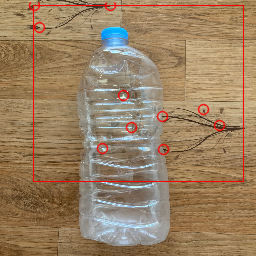

In [125]:
# 시와 토마시 코너 검출 (corner_goodFeature.py)
image = cv2.imread(args2["input"])

image2 = cv2.resize(image, (256,256))

img = image2
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 시-토마스의 코너 검출 메서드
corners = cv2.goodFeaturesToTrack(gray, 10, 0.01, 10)
# 실수 좌표를 정수 좌표로 변환
corners = np.int32(corners)

# 좌표에 동그라미 표시
for corner in corners:
    x, y = corner[0]
    cv2.circle(img, (x, y), 5, (0,0,255), 1, cv2.LINE_AA)

x1, y1, x2, y2 = return_rect_points(keypoints)
print(x1, y1, x2, y2)
cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255))

cv2_imshow(gray)
cv2_imshow(img)
cv2.waitKey()
cv2.destroyAllWindows()

## 영상 인식 및 모델 사용

[참고](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=dldudcks1779&logNo=222057069532)


In [ ]:
##### 실행 #####
# 비디오를 저장하지 않을 경우
# webcam : sudo python3 real_time_object_detection.py
# 예) sudo python3 real_time_object_detection.py
# video : sudo python3 real_time_object_detection.py --input 비디오 경로
# 예) sudo python3 real_time_object_detection.py --input ./test_video/test_video_1.mp4
#
# 비디오를 저장할 경우
# webcam : sudo python3 real_time_object_detection.py --output 저장할 비디오 경로
# 예) sudo python3 real_time_object_detection.py --output ./result_video/result_video_1.avi
# video : sudo python3 real_time_object_detection.py --input 비디오 경로 --output 저장할 비디오 경로
# 예) sudo python3 real_time_object_detection.py --input ./test_video/test_video_1.mp4 --output ./result_video/result_video_1.avi

# 필요한 패키지 import
from imutils.video import FPS
import numpy as np # 파이썬 행렬 수식 및 수치 계산 처리 모듈
# import argparse # 명령행 파싱(인자를 입력 받고 파싱, 예외처리 등) 모듈
import easydict # argparse가 쥬피터에선 안됨
import imutils # 파이썬 OpenCV가 제공하는 기능 중 복잡하고 사용성이 떨어지는 부분을 보완(이미지 또는 비디오 스트림 파일 처리 등)
import time # 시간 처리 모듈
import cv2 # opencv 모듈
from google.colab.patches import cv2_imshow # cv2.imshow 대신 사용

In [21]:
opt = easydict.EasyDict({
        "input": test_path + '/IMG_5169.MOV', # input 경로
        "output": './a.avi', # output 경로
        "confidence": 0.5 # 최소 확률
})
# 입력받은 인자값을 args에 저장
args = vars(opt)

In [22]:
# 훈련된 클래스 labels 목록을 초기화
CLASSES = ['재활용가능 어그멘테이션', '재활용불가능 어그멘테이션']

# 각 클래스에 대한 bounding box 색깔 random 지정
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# 모델(caffemodel 및 prototxt) load
print("[모델 loading...]")
# net = cv2.dnn.readNetFromCaffe(path + "MobileNetSSD_deploy.prototxt.txt", path + "MobileNetSSD_deploy.caffemodel")
model = tf.keras.models.load_model('/content/drive/MyDrive/T1_PJ/CODE/PET_model_V3.h5')

[모델 loading...]


In [23]:
# input 비디오 경로가 제공되지 않은 경우 webcam
if not args.get("input", False):
    print("[webcam 시작]")
    vs = cv2.VideoCapture(0)

# input 비디오 경로가 제공된 경우 video
else:
    print("[video 시작]")
    vs = cv2.VideoCapture(args["input"])

[video 시작]


In [ ]:
# fps 정보 초기화
fps = FPS().start()

writer = None
(w, h) = (None, None)

# 비디오 스트림 프레임 반복
while True:
    # 프레임 읽기
    # type(frame) = numpy.ndarray
    ret, frame = vs.read()
    
    # 읽은 프레임이 없는 경우 종료
    if args["input"] is not None and frame is None:
        break
    
    # 프레임 크기 지정
    # frame = imutils.resize(frame, width=500)
    frame = cv2.resize(frame, (256,256))
    
    # 프레임 크기
    if w is None or h is None:
        (h, w) = frame.shape[:2]
    
    # # blob 이미지 생성
    # # 파라미터
    # # 1) image : 사용할 이미지
    # # 2) scalefactor : 이미지 크기 비율 지정
    # # 3) size : Convolutional Neural Network에서 사용할 이미지 크기를 지정
    # # 4) mean : Mean Subtraction 값을 RGB 색상 채널별로 지정해 주는 경험치 값(최적의 값)
    # blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)),	0.007843, (300, 300), 127.5)
    
    # # 객체 인식
    # net.setInput(blob)
    # detections = net.forward() # Caffe 모델이 처리한 결과값 : 4차원 배열

    img_array = tf.expand_dims(frame, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')

    # # 객체 인식 수 만큼 반복
    # for i in np.arange(0, detections.shape[2]):
    #     # 객체 확률 추출
    #     confidence = detections[0, 0, i, 2]
        
    #     # 객체 확률이 최소 확률보다 큰 경우
    #     if confidence > args["confidence"]:
    #         # 인식된 객체 index
    #         idx = int(detections[0, 0, i, 1])

    #         # bounding box 위치 계산
    #         box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    #         (startX, startY, endX, endY) = box.astype("int")
            
    #         # bounding box 출력
    #         cv2.rectangle(frame, (startX, startY), (endX, endY), COLORS[idx], 2)
            
    #         # 객체 인식된 클래스 label 및 확률
    #         label = "{} : {:.2f}%".format(CLASSES[idx], confidence * 100)

    #         # label text 잘림 방지
    #         y = startY - 15 if startY - 15 > 15 else startY + 15

    #         # label text 출력
    #         cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
    
    # 프레임 출력
    # cv2.imshow("Real-Time Object Detection", frame)
    cv2_imshow(frame)
    key = cv2.waitKey(1) & 0xFF
    
    # 'q' 키를 입력하면 종료
    if key == ord("q"):
        break
    
    # fps 정보 업데이트
    fps.update()

    # output video 설정
    if args["output"] != "" and writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(args["output"], fourcc, 25, (frame.shape[1], frame.shape[0]), True)

    # 비디오 저장
    if writer is not None:
        writer.write(frame)

# fps 정지 및 정보 출력
fps.stop()
print("[재생 시간 : {:.2f}초]".format(fps.elapsed()))
print("[FPS : {:.2f}]".format(fps.fps()))

# 종료
vs.release()
cv2.destroyAllWindows()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

avi = open('a.avi','rb').read()

data_url = "data:video/avi;base64," + b64encode(avi).decode()
HTML(""" 
<video width=500 controls> 
  <source src="%s" type="video/avi"> 
</video> """ % data_url)